In [1]:
import pandas as pd
import psutil

from freeholdforecast.tasks.etl_ml_task import ETL_ML_Task

pd.options.display.max_columns = 100

task = ETL_ML_Task()


2022-11-06 23:05:37 INFO ETL_ML_Task Initializing task for ohio-hamilton with run date 2021-10-01
2022-11-06 23:05:37 INFO ETL_ML_Task Train years: 5
2022-11-06 23:05:37 INFO ETL_ML_Task Train dates: 2016-09-01 to 2021-09-01
2022-11-06 23:05:37 INFO ETL_ML_Task Test dates: 2021-10-01 to 2021-10-01


In [2]:
task._get_df_raw_encoded()


2022-11-06 23:05:37 INFO ETL_ML_Task Loading existing raw data
2022-11-06 23:05:38 INFO ETL_ML_Task Total parcels: 281843
2022-11-06 23:05:38 INFO ETL_ML_Task Total sales: 500925
2022-11-06 23:05:38 INFO ETL_ML_Task Loading existing encoded data


In [3]:
task._get_df_prepared()


2022-11-06 23:05:38 INFO ETL_ML_Task Preparing data
2022-11-06 23:06:21 INFO ETL_ML_Task Saving prepared data
2022-11-06 23:06:23 INFO ETL_ML_Task Splitting data


In [4]:
task._train_models()


2022-11-05 16:14:18 INFO ETL_ML_Task Total labels: 4
2022-11-05 16:14:18 INFO ETL_ML_Task Jobs per label: 3
2022-11-05 16:14:18 INFO ETL_ML_Task Total fit minutes: 60
2022-11-05 16:14:18 INFO ETL_ML_Task Job fit minutes: 15
2022-11-05 16:14:18 INFO ETL_ML_Task Job memory limit (MB): 3072
2022-11-05 16:14:18 INFO ETL_ML_Task Initialize AutoML for sale_in_3_months
2022-11-05 16:14:19 INFO ETL_ML_Task Train labels: 41120/3152730 (1.30%)
2022-11-05 16:14:19 INFO ETL_ML_Task Test labels: 675/55233 (1.22%)
2022-11-05 16:14:19 INFO ETL_ML_Task Initialize AutoML for sale_in_6_months
2022-11-05 16:14:19 INFO ETL_ML_Task Train labels: 80111/3152730 (2.54%)
2022-11-05 16:14:19 INFO ETL_ML_Task Test labels: 1316/55233 (2.38%)
2022-11-05 16:14:19 INFO ETL_ML_Task Initialize AutoML for sale_in_12_months
2022-11-05 16:14:19 INFO ETL_ML_Task Train labels: 154050/3152730 (4.89%)
2022-11-05 16:14:19 INFO ETL_ML_Task Test labels: 2496/55233 (4.52%)
2022-11-05 16:14:19 INFO ETL_ML_Task Initialize AutoML f

/home/vscode/.local/share/virtualenvs/freehold-forecast-zrIN4e5_/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42755 instead
  warnings.warn(
/home/vscode/.local/share/virtualenvs/freehold-forecast-zrIN4e5_/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37247 instead
  warnings.warn(
/home/vscode/.local/share/virtualenvs/freehold-forecast-zrIN4e5_/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33863 instead
  warnings.warn(


[WARNING] [2022-11-05 16:14:59,726:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-11-05 16:21:34,709:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
2022-11-05 17:14:18 INFO ETL_ML_Task Saving model for next_sale_amount


/home/vscode/.local/share/virtualenvs/freehold-forecast-zrIN4e5_/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


2022-11-05 17:14:23 INFO ETL_ML_Task Saving model for sale_in_12_months
2022-11-05 17:14:23 INFO ETL_ML_Task Saving model for sale_in_6_months
2022-11-05 17:14:23 INFO ETL_ML_Task Saving model for sale_in_3_months


/home/vscode/.local/share/virtualenvs/freehold-forecast-zrIN4e5_/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/home/vscode/.local/share/virtualenvs/freehold-forecast-zrIN4e5_/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/home/vscode/.local/share/virtualenvs/freehold-forecast-zrIN4e5_/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


2022-11-05 17:16:09 INFO ETL_ML_Task Model metrics for sale_in_3_months
2022-11-05 17:16:10 INFO ETL_ML_Task auto-sklearn results:
  Dataset name: e8272447-5d24-11ed-a720-0242ac110002
  Metric: f1
  Best validation score: 0.498303
  Number of target algorithm runs: 19
  Number of successful target algorithm runs: 10
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 9
  Number of target algorithms that exceeded the memory limit: 0

2022-11-05 17:16:11 INFO ETL_ML_Task Pred labels: 171/55233 (0.31%)
2022-11-05 17:16:11 INFO ETL_ML_Task Precision: 0.65
2022-11-05 17:16:11 INFO ETL_ML_Task Average precision: 0.12
2022-11-05 17:16:11 INFO ETL_ML_Task ROC AUC: 0.58
2022-11-05 17:16:11 INFO ETL_ML_Task Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     54558
           1       0.65      0.16      0.26       675

    accuracy                           0.99     55233

2022-11-05 17:16:22 INFO matplotlib.font_manager generated new fontManager
2022-11-05 17:16:23 INFO ETL_ML_Task MAE for next_sale_amount: 803.67
2022-11-05 17:16:23 INFO ETL_ML_Task MAPE for next_sale_amount: 2.41
2022-11-05 17:16:23 INFO ETL_ML_Task SMAPE for next_sale_amount: 0.57
2022-11-05 17:16:23 INFO ETL_ML_Task Prediction interval for next_sale_amount: 9620.32


<IPython.core.display.Javascript object>


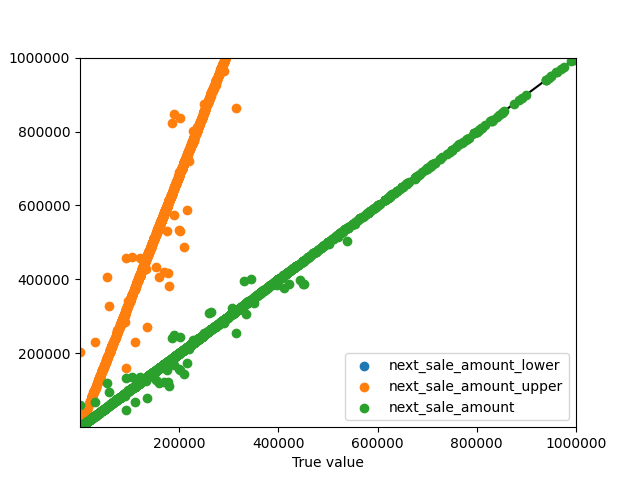

In [5]:
import matplotlib.pyplot as plt
import mlflow
import numpy as np

from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def get_prediction_interval(y_true, y_pred, pi=0.9):
    sum_errs = np.sum((y_true - y_pred)**2)
    stdev = np.sqrt(1 / (len(y_true) - 2) * sum_errs)
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    return z_score * stdev

%matplotlib notebook

label_name = "next_sale_amount"

df_train = task.df_test.loc[task.df_test[label_name].notna()]
X_train = df_train.drop(columns=task.label_names).to_numpy()
y_train = df_train[label_name].values

model = mlflow.sklearn.load_model(task.model_directories[label_name])
y_pred = model.predict(X_train)

df_temp = df_train.drop(columns=task.label_names).copy()
df_temp["y_train"] = y_train
df_temp["y_pred"] = y_pred
df_temp["y_train_pred_diff"] = df_temp.y_train - df_temp.y_pred
df_temp = df_temp.loc[abs(df_temp.y_train_pred_diff - np.mean(df_temp.y_train_pred_diff)) < 2 * np.std(df_temp.y_train_pred_diff)]

y_train = df_temp["y_train"]
y_pred = df_temp["y_pred"]

mae_value = mean_absolute_error(y_train, y_pred)
task.logger.info(f"MAE for {label_name}: {mae_value:.2f}")

mape_value = mean_absolute_percentage_error(y_train, y_pred)
task.logger.info(f"MAPE for {label_name}: {mape_value:.2f}")

smape_value = symmetric_mean_absolute_percentage_error(y_train, y_pred)
task.logger.info(f"SMAPE for {label_name}: {smape_value:.2f}")

prediction_interval = get_prediction_interval(y_train, y_pred)
task.logger.info(f"Prediction interval for {label_name}: {prediction_interval:.2f}")
    
y_pred_interval = df_temp.y_pred * mape_value
df_temp["y_pred_lower"] = df_temp.y_pred - y_pred_interval
df_temp["y_pred_upper"] = df_temp.y_pred + y_pred_interval

y_train = df_temp.y_train
y_pred = df_temp.y_pred
y_pred_upper = df_temp.y_pred_upper
y_pred_lower = df_temp.y_pred_lower

plt.scatter(y_train, y_pred_lower, label=f"{label_name}_lower")
plt.scatter(y_train, y_pred_upper, label=f"{label_name}_upper")
plt.scatter(y_train, y_pred, label=label_name)

plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.legend()
# plot_min_max = [1, max(y_train + y_pred)]
plot_min_max = [1, 1000000]
# plot_min_max = [1, 20]
plt.plot(plot_min_max, plot_min_max, c="k", zorder=0)
plt.xlim(plot_min_max)
plt.ylim(plot_min_max)
plt.ticklabel_format(style="plain")
plt.show()


In [6]:
df_temp.describe().astype(object)


,month,dates_since_last_sale,Tax District,Land Value,Building Value,Property Class,Sale Price,Valid Sale,Parid,y_train,y_pred,y_train_pred_diff,y_pred_lower,y_pred_upper
count,2467.0,2467.0,2467.0,2467.0,2467.0,2467.0,2467.0,2467.0,2467.0,2467.0,2467.0,2467.0,2467.0,2467.0
mean,10.0,92.030401,58.858127,9767.461289,21740.161735,99.86664,12232.648561,2.855695,140743.327523,370395.834617,370215.791447,180.04317,-522183.310031,1262614.892925
std,0.0,81.875696,31.404655,5574.016066,14953.24737,17.459943,8847.516044,0.517585,83039.006942,1178135.912823,1178026.304675,5844.780278,1661586.807723,4017639.417072
min,10.0,0.0,31.0,0.0,0.0,0.0,1.0,1.0,4699.0,10.0,115.067568,-65435.790039,-50577447.852261,392.436055
25%,10.0,28.0,31.0,5669.0,5765.0,104.0,4427.0,3.0,66826.0,144500.0,143260.67688,-5.106934,-480379.198895,488588.192017
50%,10.0,63.0,49.0,8771.0,26163.0,104.0,10316.0,3.0,137737.0,217500.0,217986.19873,4.438965,-307465.96289,743438.360351
75%,10.0,143.5,81.0,13585.0,35624.0,104.0,20660.0,3.0,214634.0,340000.0,340577.651367,16.256592,-202066.838257,1161534.501629
max,10.0,285.0,135.0,21570.0,41112.0,138.0,28075.0,3.0,281726.0,35860000.0,35858231.25,67883.428711,-162.30092,122293910.352261


In [7]:
import mlflow
import os

from datetime import datetime
from dateutil.rrule import rrule, MONTHLY
from sklearn.metrics import mean_absolute_percentage_error

df_current = (
    task.df_raw_encoded
        .sort_values(by=["Parid", "last_sale_date"], ascending=True)
        .drop_duplicates(subset="Parid", keep="last")
        .reset_index(drop=True)
)

def get_parcel_predict_data(last_sale_date):
    return len([x for x in rrule(dtstart=last_sale_date, until=current_date, freq=MONTHLY)])

current_date = datetime.now().replace(day=1)
df_current["year"] = current_date.year
df_current["month"] = current_date.month
df_current["dates_since_last_sale"] = df_current["last_sale_date"].parallel_apply(get_parcel_predict_data)

train_columns = list(task.df_train.drop(columns=task.label_names).columns)
X_current = df_current[train_columns].to_numpy()

for label_name in task.classification_label_names:
    task.logger.info(f"Loading predictions for {label_name}")
    model = mlflow.sklearn.load_model(task.model_directories[label_name])
    
    df_current[label_name] = [y[1] for y in model.predict_proba(X_current)]

    for pred_proba in [0.5, 0.6, 0.7, 0.8, 0.9]:
        predicted_parcels = len(df_current.loc[df_current[label_name] > pred_proba])
        task.logger.info(f"Predicted with proba {pred_proba}: {predicted_parcels}")

df_current = df_current.loc[
    (
        (df_current.sale_in_3_months > 0.5) |
        (df_current.sale_in_6_months > 0.5) |
        (df_current.sale_in_12_months > 0.5)
    )
]
X_current = df_current[train_columns].to_numpy()
        
for label_name in task.regression_label_names:
    task.logger.info(f"Loading predictions for {label_name}")
    model = mlflow.sklearn.load_model(task.model_directories[label_name])
    y_pred_current = model.predict(X_current)
    df_current["next_sale_amount"] = y_pred_current
    
    df_train = task.df_train.loc[task.df_train[label_name].notna()]
    X_train = df_train.drop(columns=task.label_names).to_numpy()
    y_train = df_train[label_name].values
    y_pred_train = model.predict(X_train)

    mape_value = mean_absolute_percentage_error(y_train, y_pred_train)
    task.logger.info(f"MAPE for {label_name}: {mape_value:.2f}")
    
    y_pred_current_interval = y_pred_current * mape_value
    df_current["next_sale_amount_lower"] = y_pred_current - y_pred_current_interval
    df_current["next_sale_amount_upper"] = y_pred_current + y_pred_current_interval
    
df_current


2022-11-05 17:18:51 INFO ETL_ML_Task Loading predictions for sale_in_3_months
2022-11-05 17:18:55 INFO ETL_ML_Task Predicted with proba 0.5: 432
2022-11-05 17:18:55 INFO ETL_ML_Task Predicted with proba 0.6: 235
2022-11-05 17:18:55 INFO ETL_ML_Task Predicted with proba 0.7: 112
2022-11-05 17:18:55 INFO ETL_ML_Task Predicted with proba 0.8: 54
2022-11-05 17:18:55 INFO ETL_ML_Task Predicted with proba 0.9: 32
2022-11-05 17:18:55 INFO ETL_ML_Task Loading predictions for sale_in_6_months
2022-11-05 17:19:00 INFO ETL_ML_Task Predicted with proba 0.5: 1803
2022-11-05 17:19:00 INFO ETL_ML_Task Predicted with proba 0.6: 374
2022-11-05 17:19:00 INFO ETL_ML_Task Predicted with proba 0.7: 73
2022-11-05 17:19:00 INFO ETL_ML_Task Predicted with proba 0.8: 18
2022-11-05 17:19:00 INFO ETL_ML_Task Predicted with proba 0.9: 6
2022-11-05 17:19:00 INFO ETL_ML_Task Loading predictions for sale_in_12_months
2022-11-05 17:19:06 INFO ETL_ML_Task Predicted with proba 0.5: 7040
2022-11-05 17:19:06 INFO ETL_ML_

,Book,Plat,Parcel,ParcelID,Tax District,Owner Name 1,Owner Name 2,Land Value,Building Value,Property Class,House #,Street Name,Street Suffix,Zip Code,Month of Sale,Day of Sale,Year of Sale,# of Parcels Sold,Sale Price,Valid Sale,Conveyance #,Deed Type,Appraisal Area,PriorOwner,PropertyNumber,Parid,last_sale_date,last_sale_amount,year,month,dates_since_last_sale,sale_in_3_months,sale_in_6_months,sale_in_12_months,next_sale_amount,next_sale_amount_lower,next_sale_amount_upper
3039,137.0,10.0,58.0,0.0,77.0,228710.0,2.0,21570.0,41112.0,16.0,1.0,1801.0,14.0,25601.0,0.0,10.0,8.0,2.0,25035.0,3.0,241968.0,50.0,101.0,207547.0,175790.0,3039.0,2006-01-01,779400,2022,11,203,0.054677,0.000182,0.592094,269320.427734,258118.847782,280522.007687
3829,140.0,10.0,18.0,0.0,96.0,42592.0,47853.0,21570.0,41112.0,31.0,1.0,17719.0,2.0,25601.0,7.0,16.0,6.0,2.0,25856.0,3.0,88769.0,50.0,101.0,207547.0,175790.0,3829.0,2004-08-01,82900,2022,11,220,0.066899,0.000534,0.600816,113959.945312,109220.121269,118699.769356
3833,141.0,2.0,166.0,0.0,83.0,316361.0,2.0,21570.0,41112.0,23.0,1.0,6848.0,40.0,25601.0,9.0,12.0,7.0,2.0,27088.0,1.0,229909.0,50.0,101.0,207547.0,175790.0,3833.0,2005-10-01,91700,2022,11,206,0.026739,0.000355,0.587270,110870.428711,106259.103896,115481.753526
4306,164.0,177.0,117.0,0.0,78.0,193756.0,25136.0,21570.0,41112.0,7.0,1.0,2561.0,47.0,25601.0,7.0,23.0,8.0,2.0,25046.0,1.0,276027.0,50.0,101.0,207547.0,175790.0,4306.0,2006-08-01,7800,2022,11,196,0.063501,0.001004,0.587618,269409.143555,258203.873732,280614.413377
4372,169.0,0.0,125.0,0.0,31.0,90641.0,2.0,4492.0,33369.0,104.0,23840.0,15339.0,31.0,25601.0,1.0,11.0,7.0,2.0,26133.0,3.0,171741.0,50.0,101.0,207547.0,175790.0,4372.0,2005-02-01,84900,2022,11,214,0.626318,0.195175,0.123040,104718.270142,100362.826014,109073.714269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281620,756.0,26.0,77.0,0.0,72.0,303924.0,19476.0,9896.0,37237.0,104.0,6335.0,18933.0,21.0,6349.0,6.0,16.0,16.0,2.0,965.0,3.0,291106.0,44.0,76.0,77957.0,175626.0,281620.0,2014-07-01,109000,2022,11,101,0.208615,0.566602,0.581366,550084.865234,527205.725875,572964.004594
281689,756.0,28.0,54.0,0.0,72.0,37561.0,9340.0,9824.0,37432.0,104.0,10775.0,20263.0,21.0,5704.0,9.0,5.0,17.0,2.0,402.0,3.0,340820.0,50.0,76.0,13697.0,175678.0,281689.0,2015-10-01,103450,2022,11,86,0.222448,0.363548,0.634784,216157.312500,207166.893769,225147.731231
281736,756.0,29.0,30.0,0.0,72.0,270284.0,57351.0,10721.0,132.0,104.0,10931.0,10226.0,17.0,13929.0,2.0,3.0,23.0,2.0,3959.0,3.0,154850.0,47.0,76.0,53089.0,175713.0,281736.0,2021-03-01,143000,2022,11,21,0.225546,0.423489,0.557068,176261.596680,168930.521260,183592.672099
281769,756.0,29.0,94.0,0.0,72.0,153312.0,57351.0,10721.0,153.0,104.0,10928.0,10226.0,17.0,13936.0,0.0,5.0,24.0,2.0,7519.0,1.0,179301.0,47.0,76.0,77443.0,175738.0,281769.0,2022-01-01,200000,2022,11,11,0.207467,0.230748,0.647710,269457.940430,258250.641047,280665.239813
